# Binary Classification using VGG16 architecture 
- using tensorflow

In [1]:
# package and module
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_files
from tensorflow.keras.utils import to_categorical, load_img
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications import vgg16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

In [2]:
# ignore warning message
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data load
train_dir = os.path.join('./train_set')
valid_dir = os.path.join('./valid_set')
test_dir = os.path.join('./test_set')

# image class path
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [4]:
# check the number of files
train_cats_file = os.listdir(train_cats_dir)
train_dogs_file = os.listdir(train_dogs_dir)
valid_cats_file = os.listdir(valid_cats_dir)
valid_dogs_file = os.listdir(valid_dogs_dir)
test_cats_file = os.listdir(test_cats_dir)
test_dogs_file = os.listdir(test_dogs_dir)
print('Total train cats images:', len(train_cats_file))
print('Total train dogs images:', len(train_dogs_file))
print('Total valid cats images:', len(valid_cats_file))
print('Total valid dogs images:', len(valid_dogs_file))
print('Total test cats images:', len(test_cats_file))
print('Total test dogs images:', len(test_dogs_file))

Total train cats images: 2389
Total train dogs images: 2535
Total valid cats images: 372
Total valid dogs images: 500
Total test cats images: 710
Total test dogs images: 750


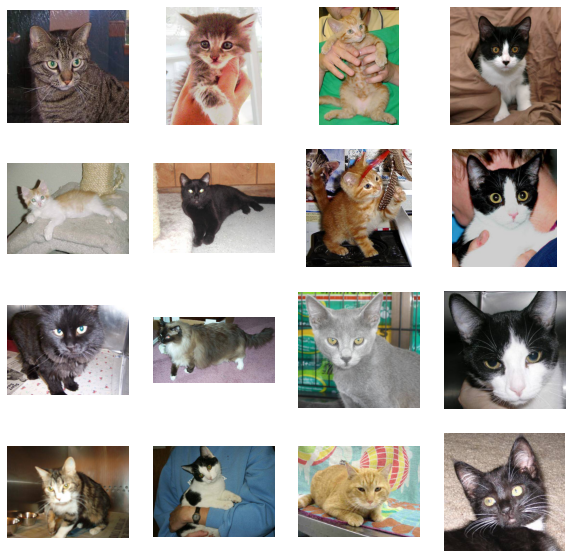

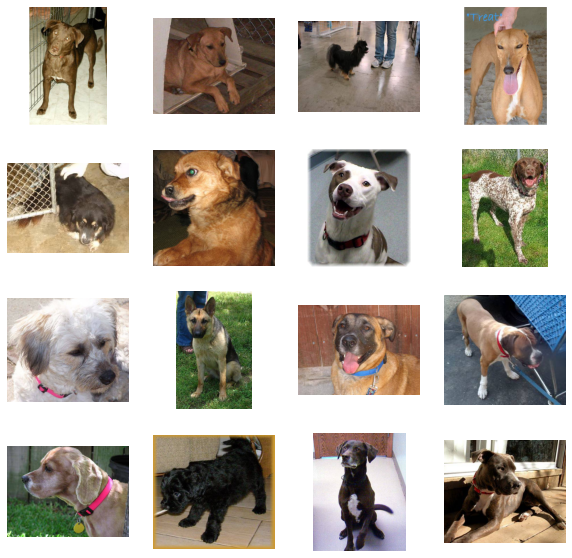

In [5]:
# show image
train_cat_image = [os.path.join(train_cats_dir, fname)
                   for fname in train_cats_file]
train_dog_image = [os.path.join(train_dogs_dir, fname)
                   for fname in train_dogs_file]

def show_image(nrows, ncols, data_path):
    plt.figure(figsize=(10,10))
    for i in range(nrows*ncols):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(Image.open(data_path[i]))
        plt.axis('off')
    plt.show()

nrows, ncols = 4, 4
show_image(nrows, ncols, train_cat_image)
show_image(nrows ,ncols ,train_dog_image)

In [6]:
# data preprocessing
batch_size = 32
target_size = (224,224)

# train
train_gen = ImageDataGenerator(rescale=1/255., data_format='channels_last')
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')
# valid
valid_gen = ImageDataGenerator(rescale=1/255., data_format='channels_last')
valid_generator = valid_gen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')

Found 4924 images belonging to 2 classes.
Found 872 images belonging to 2 classes.


In [7]:
# load the vgg16 model
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# set it's not pre-trained
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# create new model that add gap, dense layer
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# hyperparameter setting with early stopping and model compile
lr = 1e-3
opt = keras.optimizers.Adam(learning_rate=lr)
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
new_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# model training
EPOCH = 100
history = new_model.fit_generator(train_generator,
                                  epochs=EPOCH,
                                  validation_data=valid_generator,
                                  shuffle=True,
                                  callbacks=[earlystop])

Epoch 1/100
154/154 [==============================] - 23s 104ms/step - loss: 0.3564 - accuracy: 0.8400 - val_loss: 0.3249 - val_accuracy: 0.8727
Epoch 2/100
154/154 [==============================] - 11s 71ms/step - loss: 0.2391 - accuracy: 0.8948 - val_loss: 0.2087 - val_accuracy: 0.9197
Epoch 3/100
154/154 [==============================] - 11s 69ms/step - loss: 0.2370 - accuracy: 0.9019 - val_loss: 0.1386 - val_accuracy: 0.9495
Epoch 4/100
154/154 [==============================] - 11s 68ms/step - loss: 0.2236 - accuracy: 0.9050 - val_loss: 0.1231 - val_accuracy: 0.9610
Epoch 5/100
154/154 [==============================] - 11s 72ms/step - loss: 0.2171 - accuracy: 0.9096 - val_loss: 0.1617 - val_accuracy: 0.9312
Epoch 6/100
154/154 [==============================] - 12s 75ms/step - loss: 0.2110 - accuracy: 0.9088 - val_loss: 0.2959 - val_accuracy: 0.8681
Epoch 7/100
154/154 [==============================] - 11s 73ms/step - loss: 0.2103 - accuracy: 0.9163 - val_loss: 0.1258 - val_a

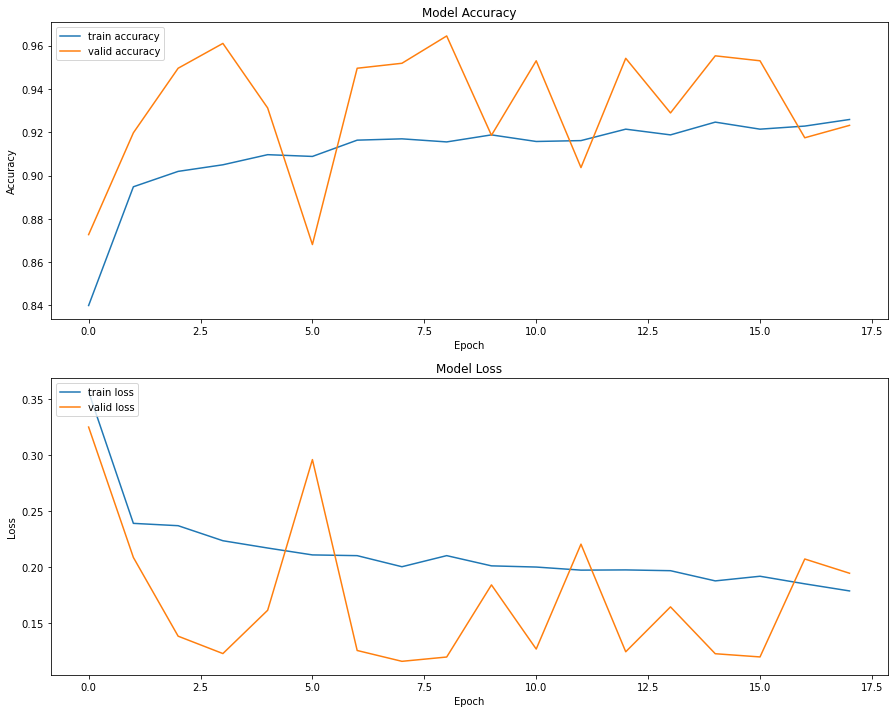

In [11]:
# check accuracy and loss
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
#plt.ylim(0,1)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0,1)
plt.legend(loc='upper left')
plt.show()

In [12]:
# load test data
def load_data(path):
    data = load_files(path)
    files = data.filenames
    targets = to_categorical(data.target)
    targets = np.argmax(targets, axis=1)
    return files, targets

test_dir = './test_set'
test_image, test_label = load_data(test_dir)

In [13]:
test_image

array(['./test_set\\cats\\cat.4736.jpg', './test_set\\cats\\cat.4682.jpg',
       './test_set\\cats\\cat.4628.jpg', ...,
       './test_set\\dogs\\dog.4674.jpg', './test_set\\cats\\cat.4778.jpg',
       './test_set\\cats\\cat.4969.jpg'], dtype='<U31')

In [14]:
# image -> 4d tensor
def image_to_tensor(files):
    images = []
    for file in files:
        img = load_img(file, target_size=(224,224))
        img = img_to_array(img)
        images.append(img/255.)
    return np.array(images)

X_test = image_to_tensor(test_image)
y_test = test_label

In [15]:
# predict test set
prediction = new_model.predict(X_test)

In [16]:
# check model performance
test_loss, test_acc = new_model.evaluate(X_test, y_test)
print(f'Error: {test_loss}, Accuracy: {round(test_acc*100)}%')

46/46 [==============================] - 2s 35ms/step - loss: 0.2151 - accuracy: 0.9110
Error: 0.21506091952323914, Accuracy: 91%


In [17]:
# create prediction data frame for checking result
pred_df = pd.DataFrame(np.round(prediction), columns=['label'])
cat = pred_df[pred_df.label==0].index
dog = pred_df[pred_df.label==1].index

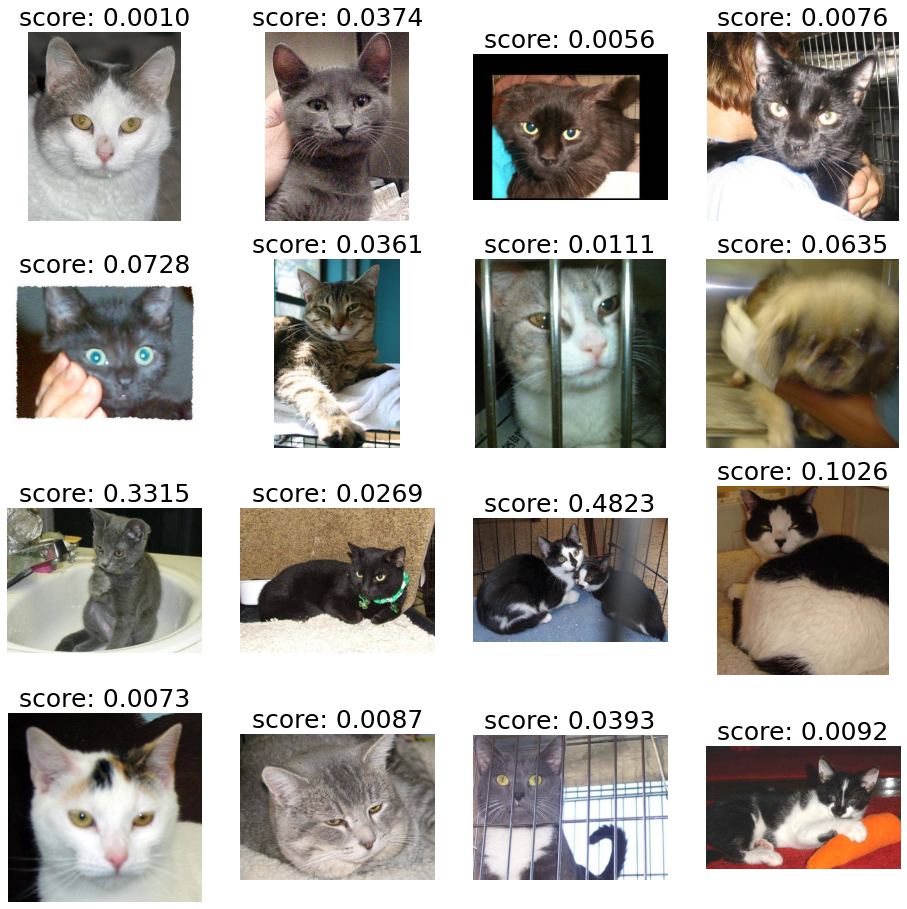

In [22]:
# show score with image
def show_image_with_score(nrow, ncol, class_name):
    plt.figure(figsize=(16,16))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(Image.open(test_image[class_name[i]]))
        plt.title('score: {0:.4f}'.format(prediction[class_name[i]][0]), fontsize=25)
        plt.axis('off')
    plt.show()

show_image_with_score(4,4,cat)

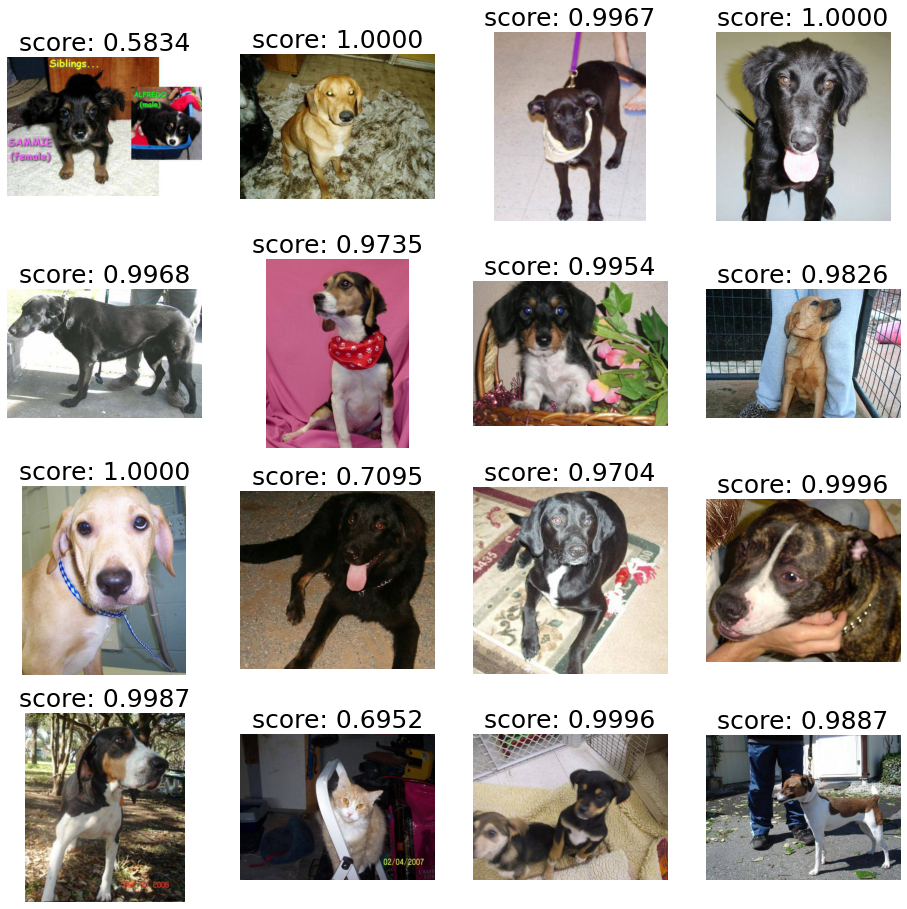

In [23]:
show_image_with_score(4,4,dog)